# TSM Assignment 

Overleaf: https://www.overleaf.com/5382115821nbvwqrncqwrc

#### Libraries

In [1]:
import pandas as pd
import numpy as np
import scipy
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

#### Data 

In [2]:
# Read data (Skipping lines without data)
data_real = pd.read_csv("data_real.csv", sep=",", skiprows=18)
data_nom = pd.read_csv("data_nom.csv", sep=",", skiprows=9)

# Select maturities 2, 3, 5, 7, 10 years and end_of_month dates
data_real = data_real.query("Date >= '2005-01-01' and Date <= '2022-08-31'").set_index('Date')
data_real = data_real[['TIPSY02', 'TIPSY03', 'TIPSY05', 'TIPSY07', 'TIPSY10']]

data_nom = data_nom.query("Date >= '2005-01-01' and Date <= '2022-08-31'").set_index('Date')
data_nom = data_nom[['SVENY02', 'SVENY03', 'SVENY05', 'SVENY07', 'SVENY10']]

data_nom.index = pd.to_datetime(data_nom.index)
data_nom = data_nom.resample('M').last()
data_nom.index = data_nom.index.strftime('%Y-%b')

data_real.index = pd.to_datetime(data_real.index)
data_real = data_real.resample('M').last()
data_real.index = data_real.index.strftime('%Y-%b')

data_all = pd.concat([data_nom,data_real],axis=1)

# Q1

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


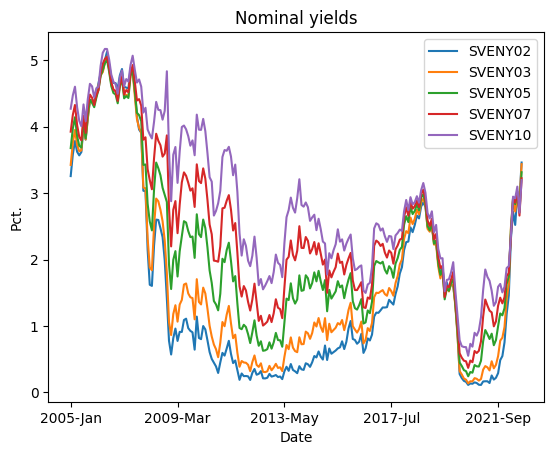

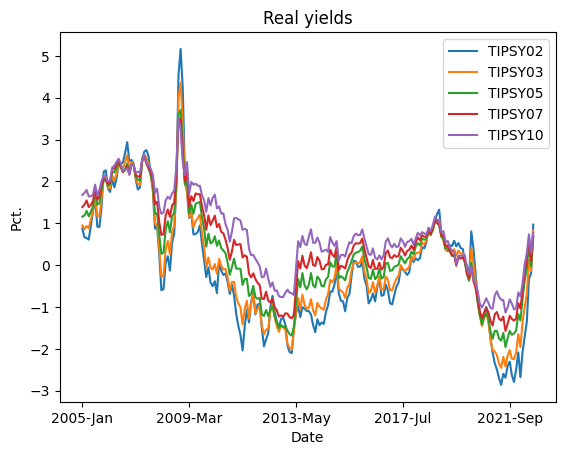

In [3]:
fig_nom = data_nom.plot(title='Nominal yields', ylabel='Pct.')
fig_nom = fig_nom.get_figure()
fig_nom.savefig('01_nom.eps',format='eps')

fig_real = data_real.plot(title='Real yields', ylabel='Pct.')
fig_real = fig_real.get_figure()
fig_real.savefig('01_real.eps',format='eps')

plt.show()

# Q2

In [4]:
scaler = StandardScaler()
nom_std = scaler.fit_transform(data_nom)
real_std = scaler.fit_transform(data_real)

pca_real = PCA(n_components=5)
pca_nom = PCA(n_components=5)

X_real = pca_real.fit_transform(real_std)
X_nom = pca_nom.fit(nom_std)


df = pd.DataFrame(
    {
        'EVar_Real': np.round(pca_real.explained_variance_ratio_,4)*100,
        'EVar_Nom': np.round(pca_nom.explained_variance_ratio_,4)*100,
        'Cum_EVar_Real': np.cumsum(np.round(pca_real.explained_variance_ratio_,4)*100),
        'Cum_EVar_Nom': np.cumsum(np.round(pca_nom.explained_variance_ratio_,4)*100) 
    }, index=range(1,6))
df.index.name = 'PCA Components'
print(df)

                EVar_Real  EVar_Nom  Cum_EVar_Real  Cum_EVar_Nom
PCA Components                                                  
1                   96.05     93.09          96.05         93.09
2                    3.72      6.75          99.77         99.84
3                    0.22      0.16          99.99        100.00
4                    0.01      0.00         100.00        100.00
5                    0.00      0.00         100.00        100.00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


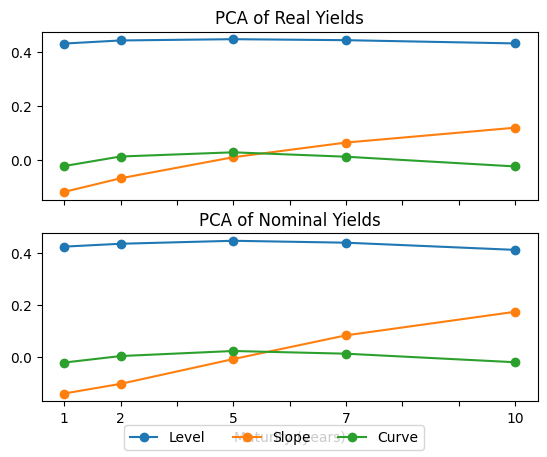

In [5]:
fig, ax = plt.subplots(2,1, sharex=True)
x = [2,3,5,7,10]

loadings_real = (pca_real.components_.T * np.sqrt(pca_real.explained_variance_ratio_)).T
loadings_nom = (pca_nom.components_.T * np.sqrt(pca_nom.explained_variance_ratio_)).T


ax[0].plot(x,loadings_real[0],label='Level',marker='o')
ax[0].plot(x,loadings_real[1],label='Slope',marker='o')
ax[0].plot(x,loadings_real[2],label='Curve',marker='o')
ax[0].set_title('PCA of Real Yields')
ax[0].set_xticklabels(['',1,2,'',5,'',7,'','',10])

ax[1].plot(x,loadings_nom[0],label='Level',marker='o')
ax[1].plot(x,loadings_nom[1],label='Slope',marker='o')
ax[1].plot(x,loadings_nom[2],label='Curve',marker='o')
ax[1].set_title('PCA of Nominal Yields')
ax[1].set_xticklabels(['',1,2,'',5,'',7,'','',10])
ax[1].set_xlabel('Maturity (years)')

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3)
fig.savefig('02_PCARealNominal.eps',format='eps')


# Q3

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


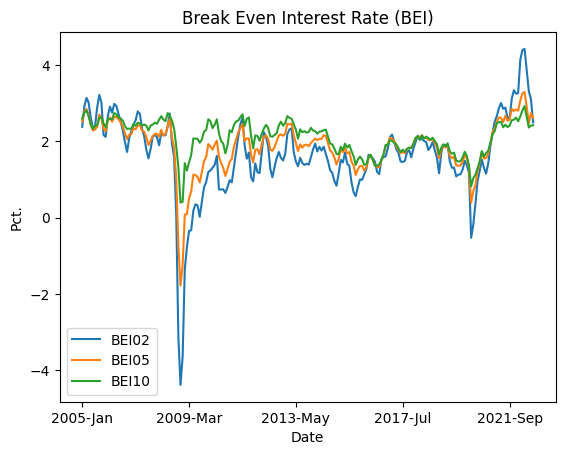

In [6]:
# BEI rates for maturities of 2, 5, 10 years
data_bei = data_nom.join(data_real, on = 'Date')

for x in ['02', '05', '10']:
    data_bei['BEI' + x] = data_bei['SVENY' + x] - data_bei['TIPSY' + x]

data_bei = data_bei[['BEI02', 'BEI05', 'BEI10']] 


fig, ax = plt.subplots()
data_bei.plot(ax = ax)
ax.set_ylabel('Pct.')
ax.set_title('Break Even Interest Rate (BEI)')
fig.savefig('03_BEI.eps',format='eps')


# Q5

In [7]:
# Parameters 
lambda_ = 0.5
X = np.array([0.02, -0.02])


def alpha(tau, sigma_L=0.005, sigma_S=0.01, lambda_=0.5):
    return sigma_L**2*tau**3/6 + sigma_S**2/(2*lambda_**2) * (tau - (np.exp(-2*lambda_*tau)-1)/(2*lambda_) + (2*np.exp(-lambda_*tau)-2)/lambda_)

def beta(tau,lambda_=0.5):
    return np.array([-(tau),-1/lambda_ + np.exp(-lambda_*tau)/lambda_])

def P(tau, X):
    if isinstance(tau, float) or isinstance(tau, int):
        return np.exp(alpha(tau)+beta(tau).T @ X)        
    return np.exp(alpha(tau)+beta(tau).T @ X)[0]

def y(tau,X):
    return 0.0 if tau == 0 else -np.log(P(tau,X)) / (tau)


print(round(pd.DataFrame({'1Y': [P(1,X), y(1,X)],
                    '5Y': [P(5,X), y(5,X)],
                    '10Y': [P(10,X), y(10,X)]}, 
                    index=['ZCB', 'YTM']),4))


         1Y      5Y     10Y
ZCB  0.9958  0.9396  0.8567
YTM  0.0042  0.0125  0.0155


# Q11

#### Helper functions

In [8]:
"""
    LinAlg Helper functions used to calculate conditional and unconditional variance-matrices 
"""

def eigen_decomp(KP, verbose=0):
    # Perform Eigen-decomposition of a matrix A = QDQ^-1,
    # where Q is a matrix with the eigenvectors of A and
    #       D is a diagonal matrix with the eigenvalues of A
    # Returns: Q, D, Q^-1
    eigenvalues, Q = np.linalg.eig(KP)
    if verbose >= 2:
        if any(eig < 0 for eig in eigenvalues):
            print("At least one of the eigenvalues are not (strictly) positive:")
            print(eigenvalues)
    D = np.diag(eigenvalues)
    return Q, D, np.linalg.inv(Q)


def calcmat_S(KP, Sigma, verbose=0):
    # Calculate S = Q^-1 S S^T (Q^-1)^T
    Q, D, Q_inv = eigen_decomp((KP), verbose)
    return Q_inv @ Sigma @ Sigma.T @ Q_inv.T


def calcmat_Vcond(KP, Sigma, tau, verbose=0):
    # Calculate V_ij = S_ij / (D_i + D_j) * (1- exp{-(D_i + D_j)*(T-t)})
    S = calcmat_S(KP, Sigma)
    Q, D, Q_inv = eigen_decomp((KP), verbose)
    V = np.zeros(np.shape(KP))

    N, M = np.shape(V)
    for i in range(N):
        for j in range(M):
            V[i, j] = S[i, j] / (D[i, i] + D[j, j]) * (1 - np.exp (-(D[i, i] + D[j, j]) * (tau)))
    return V


def calcmat_Vuncond(KP, Sigma, verbose=0):
    # Calculate V_ij = S_ij / (D_i + D_j)
    S = calcmat_S(KP, Sigma)
    Q, D, Q_inv = eigen_decomp((KP), verbose)
    V = np.zeros(np.shape(KP))

    N, M = np.shape(V)
    for i in range(N):
        for j in range(M):
            V[i, j] = S[i, j] / (D[i, i] + D[j, j])

    return V


def calcMat_condVar(KP, Sigma, tau, verbose=0):
    # Calculate uncondVar = Q V Q^T
    Q, D, Q_inv = eigen_decomp((KP), verbose)
    V = calcmat_Vcond(KP, Sigma, tau, verbose)
    return Q @ V @ Q.T


def calcMat_uncondVar(KP, Sigma, verbose=0):
    # Calculate uncondVar = Q V Q^T
    Q, D, Q_inv = eigen_decomp((KP), verbose)
    V = calcmat_Vuncond(KP, Sigma, verbose)
    return Q @ V @ Q.T


#### Infamous Kalman Class Ⓒ

In [9]:
class Kalmanfilter:
    """
    Class to initiate, estimate and evaluate a Kalman Filter on a dataset.
    Objective is to estimate the parameters of the state price variable, X(t), with P-dynamics
                dX(t) = K^P [thetaP - X(t)]dt + Sigma dW^P(t).
    Yields (both nominal and real) are denoted as y(t; tau), each of these curves have 5 tenors (tau).
    The class assumes eod of month data.
    """
    def __init__(self, df, KP, thetaP, tau_vec: np.array,
                 sigma_L_nom: float, sigma_L_real: float, sigma_S_nom: float, sigma_S_real: float,
                 lambda_nom: float, lambda_real: float, sigma_err: float, penalty: float = 1e6,
                 verbose=0):
        # Arguments
        self.df = df/100
        self.KP = KP
        self.thetaP = thetaP
        self.tau = tau_vec
        self.dt = 1 / 12

        self.sigma_L_nom = np.abs(sigma_L_nom)
        self.sigma_L_real = np.abs(sigma_L_real)
        self.sigma_S_nom = np.abs(sigma_S_nom)
        self.sigma_S_real = np.abs(sigma_S_real)
        self.penalty = penalty
        self.lambda_nom = lambda_nom
        self.lambda_real = lambda_real
        self.sigma_err = sigma_err**2
        self.verbose = verbose

        # Parameters
        self.SigmaP = np.diag([self.sigma_L_nom, self.sigma_S_nom, self.sigma_L_real, self.sigma_S_real])

        # Constants
        self.T, self.N = self.df.shape

        self.F = scipy.linalg.expm(-self.KP * self.dt)
        self.C = self.thetaP - self.F @ self.thetaP
        self.Q = np.real(calcMat_condVar(self.KP, self.SigmaP, self.dt, verbose=1))

        self.A = -np.concatenate([alpha(tau=self.tau, sigma_L=self.sigma_L_nom, sigma_S=self.sigma_S_nom, lambda_=self.lambda_nom) / self.tau,
                                  alpha(tau=self.tau, sigma_L=self.sigma_L_real, sigma_S=self.sigma_S_real, lambda_=self.lambda_real) / self.tau]).reshape(-1, 1)

        self.B = -np.block(
            [[beta(tau=self.tau, lambda_=self.lambda_nom).reshape(2, 5).T / self.tau[:, None], np.zeros([5, 2])],
             [np.zeros([5, 2]), beta(tau=self.tau, lambda_=self.lambda_real).reshape(2, 5).T / self.tau[:, None]]])
        self.H = self.sigma_err * np.eye(10)

        # Variables
        self.loglik = 0#float(self.N * self.T / 2 * np.log(2 * np.pi))

        self.Xlag = None
        self.Xt = thetaP  # Uncondition Mean
        self.Plag = None
        self.Pt = np.real(calcMat_uncondVar(self.KP, self.SigmaP, verbose=1))

        self.yt = None
        self.nut = None
        self.St = None
        self.Kt = None

        eigenvals = np.real(np.linalg.eig(self.KP)[0])

        if any(eig < 0 for eig in eigenvals):
            if self.verbose >= 3:
                print('KP has negative eigenvalues:')
                print(eigenvals)
            self.loglik += float(self.penalty)

    def predict_Xt(self):
        self.Xlag = np.real(self.F @ self.Xt + self.C)

    def predict_Pt(self):
        self.Plag = np.real(self.F @ self.Pt @ self.F.T + self.Q)

    def update_yt(self, t):
        self.yt = self.df.iloc[t, :].to_numpy().reshape(10, 1)

    def update_nut(self):
        self.nut = np.real(self.yt - self.A - self.B @ self.Xlag)

    def update_St(self):
        self.St = np.real(self.H + self.B @ self.Plag @ self.B.T)

    def update_Kt(self):
        self.Kt = np.real(self.Plag @ self.B.T @ np.linalg.inv(self.St))

    def update_Xt(self):
        self.Xt = np.real(self.Xlag + self.Kt @ self.nut)

    def update_Pt(self):
        self.Pt = np.real((np.eye(4) - self.Kt @ self.B) @ self.Plag)

    def update_loglik(self):
        det = np.linalg.det(self.St)
        if det <= 0:
            loglik_term = float(self.penalty)
        else:
            loglik_term = 1 / 2 * (np.log(det) + self.nut.T @ np.linalg.inv(self.St) @ self.nut)
        if (loglik_term < 0) and (self.verbose >= 3):
            print('Negative loglikelihood-term: \n\t log(det)={} \n\t other={}'.format(np.log(det), self.nut.T @ np.linalg.inv(self.St) @ self.nut))
        if np.iscomplex(loglik_term) and (self.verbose >= 2):
            print('Complex loglikelihoold-term: {}'.format(loglik_term))
        self.loglik += float(np.real(loglik_term))


    def fit_kalman(self):
        """ Method used to train/fit the kalman filter"""
        #self.yfit = np.empty((self.T, self.N))
        for row in range(self.T):

            # Predict step
            self.predict_Xt()
            self.predict_Pt()

            # Update step
            self.update_yt(t=row) 
            self.update_nut()
            self.update_St()
            self.update_Kt()
            self.update_Xt()
            self.update_Pt()
            self.update_loglik()

    def generate_attributes(self):
        """ Method used to generate and calculate attributes needed for evaluations on the final parameters """
        self.yfit = np.empty((self.T, self.N))
        self.xfit = np.empty((self.T + 1, 4))
        self.xfit[0, :] = self.Xt.reshape(1, 4)

        for row in range(self.T):

            # Predict step
            self.predict_Xt()
            self.predict_Pt()

            # Update step
            self.update_yt(t=row)
            self.update_nut()
            self.update_St()
            self.update_Kt()
            self.update_Xt()
            self.update_Pt()
            self.update_loglik()

            self.yfit[row, :] = (self.A + self.B @ self.Xt).reshape(1, 10)
            self.xfit[row + 1, :] = self.Xt.reshape(1, 4)


    def calc_RMSE(self):
        """ Method for calculating Root Mean Squared Error (RMSE) """
        y_obs = self.df
        y_fit = pd.DataFrame(self.yfit, columns=self.df.columns, index=self.df.index)

        self.mse = ((y_fit - y_obs)**2).mean(axis=0)
        self.rmse = np.sqrt(self.mse)

    # end of class

#### Optimizer functions

In [10]:
"""
    Preprocessing, helper-functions and objective funtion for fitting the kalman filter of the state price variable
"""
data_nom_real = data_nom.join(data_real)

df = data_nom_real

"""
KP = np.eye(4)                     # 16
thetaP = np.zeros((4,1))           # 4
tau_vec = np.array([2,3,5,7,10])   
sigma_L_nom=0.001                  # 1
sigma_L_real=0.001                 # 1
sigma_S_nom=0.05                   # 1
sigma_S_real=0.05                  # 1
lambda_nom = 1.0                   # 1
lambda_real = 1.0                  # 1
sigma_err = 0.01                   # 1
penalty = 1e6            

"""


def kalman_optim(x0, df, optim_func='loglik', verbose=0, penalty=1e6):
    # Format arguments
    KP = x0[:16].reshape([4, 4])
    thetaP = x0[16:20].reshape(4, 1)
    sigma_L_nom = np.abs(x0[20])
    sigma_L_real = np.abs(x0[21])
    sigma_S_nom = np.abs(x0[22])
    sigma_S_real = np.abs(x0[23])
    lambda_nom = x0[24]
    lambda_real = x0[25]
    sigma_err = x0[26]

    tau_vec = np.array([2, 3, 5, 7, 10])

    kalman = Kalmanfilter(df, KP, thetaP, tau_vec,
                          sigma_L_nom, sigma_L_real, sigma_S_nom, sigma_S_real,
                          lambda_nom, lambda_real, sigma_err, penalty, verbose)
    kalman.fit_kalman()
    loglik = kalman.loglik
    # rmse = np.max(kalman.rmse)

    if optim_func.lower() == 'loglik':
        z = loglik
    # elif optim_func.lower() == 'rmse':
    #    z = rmse

    if verbose >= 1:
        print(z)
    return z


def repeated_optim(x0, N=5, max_iter=2500, max_fev=3000, func_tol=1.0, verbose=0, tol=5E-4, fatol=5E-4, xatol=5E-4, method='Nelder-Mead'):
    """
    Helper-function for running repeated optimization with the current most optimal value

    :param x0:          Initial parameters to be optimized
    :param N:           Number of iterations in rep.
    :param max_iter:    Maximum number of iterations in the optimization step
    :param max_fev:     Maximum number of function evaluations in the optimization step
    :param func_tol:    Required improvement of function value to start another rep.
    :param verbose:     Amount of information displayed
    :return:            <scipy.optimize.OptimizeResult>-object from the optimization
    """
    f_opt = 5000
    for i in range(N):
        dt_start = datetime.now()
        print('Starting', i, 'at time ', dt_start)
        optim = scipy.optimize.minimize(fun=kalman_optim,
                                        x0=x0,
                                        args=(df, 'loglik', verbose, 1e6),
                                        # Data, optimization method, verbose, penalty
                                        method=method,
                                        tol=tol,
                                        options={'maxiter': max_iter,  # Maximum iterations
                                                 'maxfev': max_fev,
                                                 # Maximum function evaluations (might be several per iter.)
                                                 'adaptive': True,  # Better for higher dimensional problems
                                                 'disp': True,  # Display message at termination
                                                 'xatol': xatol,  # Stops when |x_n - x_{n-1}| < xatol
                                                 'fatol': fatol}  # Stops when |f_n - f_{n-1}| < fatol
                                        )
        dt_end = datetime.now()
        print('Finished', i, 'at time', dt_end)
        print('Time of iteration:\t', dt_end - dt_start)
        print(i, ':\t', optim.fun)
        print('\n' * 3)

        # Use optimal value
        x0 = optim['x']

        # Stopping criteria
        if abs(f_opt - optim.fun) < func_tol:
            print('Insufficient improvement between iterations...')
            break
        else:
            f_opt = optim.fun

    return optim


#### Estimation

In [11]:
"""
    Train / fit kalman filter to estimate parameters of the state price variable
"""

# Initial parameter values

x0 = np.array([
  2.2,  0.3,  0.4,  0.5,
  1.0,   .7,  0.8,  0.4,
   .5,   .2,  2.2,  1.3,
   -3.,  .5, -1.5,  2.5,        # KP
 
  0.02, 0.02, 0.02, 0.02,       #thetaP
 
  0.001, 0.001, 0.001, 0.001,   #sigma

  0.5, 0.5,  0.01               #lambda, lambda, sigma_err
  ])

# Check if all eigen values are positive
x0_eig_vals = np.linalg.eig(np.array(x0[:16]).reshape(4, 4))[0]

if any(x0_eig_vals < 0):
    raise ValueError('Negative eigenvalues in initial parameters: \n{}'.format(x0_eig_vals))

# Start optimization
optim = repeated_optim(x0=x0, N=10, max_iter=10000, max_fev=15000, func_tol=2, verbose=0, method='Nelder-Mead')


Starting 0 at time  2022-10-14 12:51:18.502151
Finished 0 at time 2022-10-14 13:12:16.402858
Time of iteration:	 0:20:57.900707
0 :	 -11746.695171142572




Starting 1 at time  2022-10-14 13:12:16.402858
Finished 1 at time 2022-10-14 13:34:10.055213
Time of iteration:	 0:21:53.652355
1 :	 -12702.663442280862




Starting 2 at time  2022-10-14 13:34:10.055213
Finished 2 at time 2022-10-14 13:55:14.390744
Time of iteration:	 0:21:04.335531
2 :	 -12886.688617908056




Starting 3 at time  2022-10-14 13:55:14.391742
Optimization terminated successfully.
         Current function value: -12886.698739
         Iterations: 376
         Function evaluations: 4506
Finished 3 at time 2022-10-14 14:02:05.958601
Time of iteration:	 0:06:51.566859
3 :	 -12886.69873873151




Insufficient improvement between iterations...


#### Evaluation

In [12]:

"""
    Use optimized parameters and perform evaluation
"""
x0 = optim['x']

# Format arguments
KP = x0[:16].reshape([4, 4])
thetaP = x0[16:20].reshape(4, 1)
sigma_L_nom = np.abs(x0[20])
sigma_L_real = np.abs(x0[21])
sigma_S_nom = np.abs(x0[22])
sigma_S_real = np.abs(x0[23])
lambda_nom = x0[24]
lambda_real = x0[25]
sigma_err = x0[26]

tau_vec = np.array([2, 3, 5, 7, 10])


kalman = Kalmanfilter(df, KP, thetaP, tau_vec,
                        sigma_L_nom, sigma_L_real, sigma_S_nom, sigma_S_real,
                        lambda_nom, lambda_real, sigma_err)

kalman.generate_attributes()
kalman.calc_RMSE()

X_opt = pd.DataFrame(kalman.xfit, columns=['level_nom', 'slope_nom', 'level_real', 'slope_real'])

# Q12

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


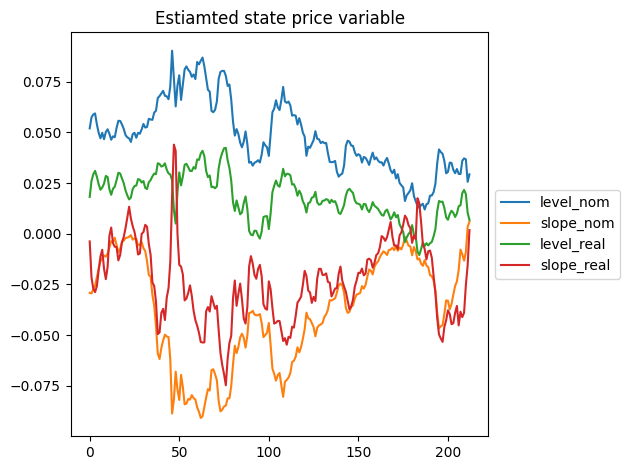

[[ 0.44 -0.05  0.   -0.22]
 [ 0.41  0.4  -0.86 -0.05]
 [ 0.15  0.14  0.55 -0.18]
 [-0.4  -0.8  -0.81  0.52]]
[ 0.05 -0.03  0.02 -0.  ]
[0.   0.   0.01 0.  ]
[0.17 0.19 0.  ]


In [13]:
X_opt.plot(title = 'Estiamted state price variable').legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()
# plt.savefig('12_state_price.png', dpi=1200)
plt.savefig('12_state_price.eps',format='eps')
plt.show()


print(np.round(x0[:16].reshape(4,4),2))
print(np.round(x0[16:20], 2))
print(np.round(x0[20:24], 2))
print(np.round(x0[24:], 2))

# Q13

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.






RMSE summary:
SVENY02    0.000614
SVENY03    0.000472
SVENY05    0.000715
SVENY07    0.000422
SVENY10    0.000772
TIPSY02    0.001050
TIPSY03    0.000435
TIPSY05    0.000965
TIPSY07    0.000510
TIPSY10    0.000687
dtype: float64


Loglikhihood =  -12886.69873873151


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


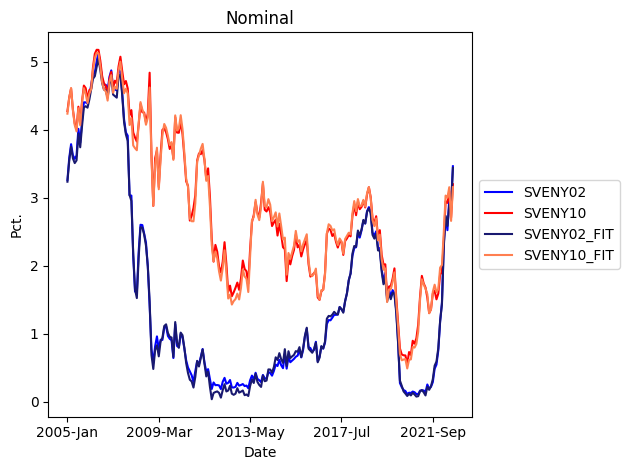

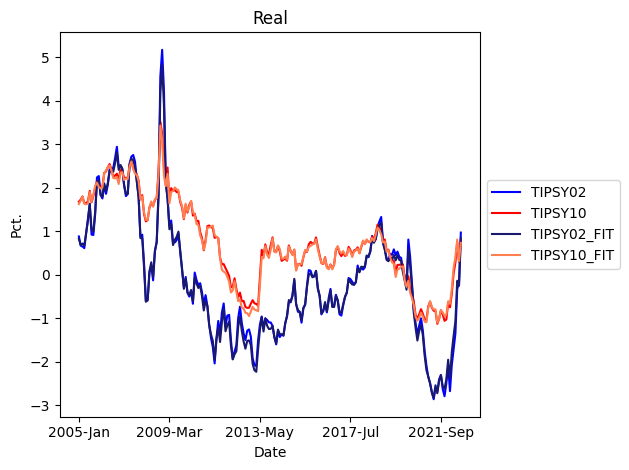

In [14]:
print('\n'*3)
print('RMSE summary:')
print(kalman.rmse)
print('\n')
print('Loglikhihood = ', kalman.loglik)

# Plot fitted yields vs. observed yields
df_fit = pd.DataFrame(kalman.yfit)
df_fit.columns = df.columns + '_FIT'
df_fit.index = df.index

df_1 = df.iloc[:, [0,4]].join(df_fit.iloc[:, [0,4]]*100)
df_2 = df.iloc[:, [5,9]].join(df_fit.iloc[:, [5,9]]*100)

df_1.plot(color=['blue', 'red', 'midnightblue', 'coral'],
          alpha=1, title='Nominal', ylabel='Pct.').legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()
# plt.savefig('nominal.png', dpi=1200)
plt.savefig('13_nominal.eps',format='eps')
df_2.plot(color=['blue', 'red', 'midnightblue', 'coral'],
          alpha=1, title='Real', ylabel='Pct.').legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()
# plt.savefig('real.png', dpi=1200)
plt.savefig('13_real.eps',format='eps')
plt.show()

# Q15

In [15]:
x0 = np.array([ 2.27104718e+00,  7.35180546e-01, -1.02171285e+00, -7.14433822e-02,
        5.90517112e-01,  6.74171317e-02, -2.06254142e+00, -1.06568638e-01,
        8.52069599e-01,  4.73273748e-01,  3.98781474e-01,  4.01713434e-02,
        2.21804541e+00, -1.19978548e-01, -3.97591691e+00,  2.28000570e-01,
        3.69435431e-02, -1.58537086e-02,  1.16769766e-02, -1.35414858e-02,
       -1.06815962e-04,  4.31290426e-03,  1.17297053e-02,  1.84270970e-03,
        1.70112361e-01,  2.14768877e-01,  8.33612860e-04])
        
# Format arguments
KP = x0[:16].reshape([4, 4])
thetaP = x0[16:20].reshape(4, 1)
sigma_L_nom = np.abs(x0[20])
sigma_L_real = np.abs(x0[21])
sigma_S_nom = np.abs(x0[22])
sigma_S_real = np.abs(x0[23])
lambda_nom = x0[24]
lambda_real = x0[25]
sigma_err = x0[26]
tau_vec = np.array([2, 3, 5, 7, 10])


kalman = Kalmanfilter(df, KP, thetaP, tau_vec,
                        sigma_L_nom, sigma_L_real, sigma_S_nom, sigma_S_real,
                        lambda_nom, lambda_real, sigma_err)

kalman.generate_attributes()
X_opt = pd.DataFrame(kalman.xfit[1:, :].T)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


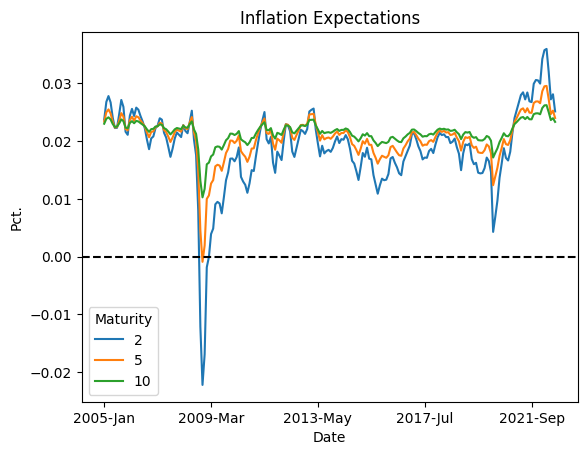

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def funcAlpha(KP,thetaP,Sigma,Beta):
    return (np.dot(np.dot(thetaP.T,KP.T), Beta) + 0.5 * np.dot(Beta.T,np.dot(Sigma,np.dot(Sigma.T,Beta))))[0][0]

def funcBeta(KP, Beta):
    return -np.array([1, 1, -1, -1]).reshape(-1,1) - np.dot(KP.T, Beta)

def calcPi(tau,A,B,X):
    return 1/(-tau) *  np.log((np.exp(A + B.T @ X)))

Sigma = np.diag([sigma_L_nom, sigma_S_nom, sigma_L_real, sigma_S_real])

df_pi = pd.DataFrame(index=range(212))


for count, tau in enumerate([2,3,5,7,10]):
    B = np.array([0,0,0,0]).reshape(-1,1)
    A = 0
    h = 0.01
    iterations = int(tau/h)

    for i in range(iterations):

        k1B = h * funcBeta(KP,B)
        k1A = h * funcAlpha(KP,thetaP,Sigma,B)

        k2B = h * funcBeta(KP,B+0.5*k1B)
        k2A = h * funcAlpha(KP,thetaP,Sigma,B+0.5*k1B)

        k3B = h * funcBeta(KP,B+0.5*k2B)
        k3A = h * funcAlpha(KP,thetaP,Sigma,B+0.5*k2B)

        k4B = h * funcBeta(KP,B+k3B)
        k4A = h * funcAlpha(KP,thetaP,Sigma,B+k3B)

        B = B + (1.0/6.0)*(k1B+2.0*k2B + 2.0*k3B + k4B)
        A = A + (1.0/6.0)*(k1A+2.0*k2A + 2.0*k3A + k4A)


    df_pi[tau] = calcPi(tau, A, B, X_opt).T


df_pi.index = data_bei.index

# Expected inflation
fig, ax = plt.subplots(1)
df_pi.drop(columns=[3,7]).plot(title='Inflation Expectations', ylabel='Pct.', ax=ax).legend(title='Maturity')
ax.axhline(y=0, xmin=0, xmax=212, color='black', linestyle='--')
plt.savefig('12_ExpectedInflation.eps',format='eps')
plt.show()


# Calculate model implied BEI
df_bei = pd.DataFrame(kalman.yfit[:, :5] - kalman.yfit[:, 5:],
                      columns=['BEI_' + x for x in ['02', '03', '05', '07', '10']], index=data_bei.index)


# Q16

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


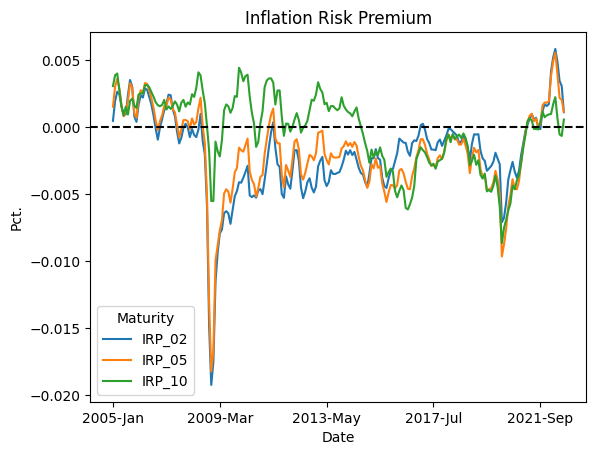

In [17]:
# Inflation risk premium
df_irp = pd.DataFrame(index=data_bei.index)

df_irp['IRP_02'] = df_bei['BEI_02'] - df_pi[2]
df_irp['IRP_05'] = df_bei['BEI_05'] - df_pi[5]
df_irp['IRP_10'] = df_bei['BEI_10'] - df_pi[10]


fig, ax = plt.subplots(1)
df_irp.plot(title='Inflation Risk Premium', ylabel='Pct.', ax=ax).legend(title='Maturity')
ax.axhline(y=0, xmin=0, xmax=212, color='black', linestyle='--')
plt.savefig('13_InflationsRisk.eps',format='eps')
plt.show()


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7a50a976-9f0c-4bbf-b229-6a6bee440451' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>